In [1]:
import numpy as np
import random as rn
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# Map
map_size = np.array([0, 10, 0, 10, 0, 10]) # min, max

# Building 0
building0 = {}
building0['Polygon'] = [(1,4), (6.5,4), (6.5,6), (1,6)]
building0['height'] = 10

# Building 1
building1 = {}
building1['Polygon'] = [(7,4), (10,4), (10,6), (7,6)]
building1['height'] = 10

"""# Building 2
building2 = {}
building2['Polygon'] = [(7,4), (10,4), (10,6), (7,6)]
building2['height'] = 10"""


building = {}
building['nb'] = 2
building['0'] = building0
building['1'] = building1
#building['2'] = building2

In [3]:
# Start, Goal
x0 = np.array([9, 1, 3])
xf = np.array([9, 9, 7])
tol = 0.1
trange = 1

In [4]:
# Other Settings
K = 100 # number of verticies
dQ = 2.5 # Incremental Distance

In [27]:
import numpy as np

# Camera Model
class Camera:
    def __init__(self, cam_pos, R, thetaH, thetaV, pan, tilt):
        self.cam_position = cam_pos[0:3]    # [x, y, z], intial position at t0
        self.cam_orientation = cam_pos[3:5] # [pan, tilt], initial position at t0
        self.R = R
        self.pan = pan                      # [min, max, angular rate]
        self.tilt = tilt                    # [min, max, angular rate]
        self.thetaH = thetaH
        self.thetaV = thetaV

    def R1(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    
    def R2(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    
    def R3(self, th):
        c = np.cos(th)
        s = np.sin(th)
        return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])
    
    def get_direc(self, timeInstance):
        R = self.R
        direc_vec = np.array([[R], [0], [0]])

        # Assume Camera in xyz Frame
        panmin = self.pan[0]
        panmax = self.pan[1]
        panRate = self.pan[2]
        tiltmin = self.tilt[0]
        tiltmax = self.tilt[1]
        tiltRate = self.tilt[2]
        translate = self.cam_position

        # Pan angle from 0 to 360
        currPan = self.cam_orientation[0] + panRate*timeInstance
        if currPan > panmax:
            currPan = panmax - np.mod(currPan, panmax)
        elif currPan < panmin:
            currPan = np.mod(currPan, panmin) + panmin

        # Tilt angle from 0 to -90
        currTilt = self.cam_orientation[1] + tiltRate*timeInstance
        if currTilt > tiltmax:
            currTilt = tiltmax - np.mod(currTilt, tiltmax)
        elif currTilt < tiltmin:
            currTilt = np.mod(currTilt, tiltmin) + tiltmin

        # Translate FOV at given timeInstance
        direc_vec = self.R3(currPan)@self.R2(currTilt)@direc_vec + np.array([[translate[0]], [translate[1]], [translate[2]]])
        return np.hstack([np.array([[translate[0]], [translate[1]], [translate[2]]]), direc_vec])

        
    def get_vertex(self, timeInstance):
        R = self.R
        thH = self.thetaH
        thV = self.thetaV

        # Compute 4 corner of FOV at given time
        vertexFOV = {}
        vertexFOV['0'] = np.array([[R], [-R*np.tan(thH/2)], [R*np.sin(thV/2)]])
        vertexFOV['1'] = np.array([[R], [-R*np.tan(thH/2)], [-R*np.sin(thV/2)]])
        vertexFOV['2'] = np.array([[R], [R*np.tan(thH/2)], [-R*np.sin(thV/2)]])
        vertexFOV['3'] = np.array([[R], [R*np.tan(thH/2)], [R*np.sin(thV/2)]])
        
        # Assume Camera in xyz Frame
        panmin = self.pan[0]
        panmax = self.pan[1]
        panRate = self.pan[2]
        tiltmin = self.tilt[0]
        tiltmax = self.tilt[1]
        tiltRate = self.tilt[2]
        translate = self.cam_position

        # Pan angle from 0 to 360
        currPan = self.cam_orientation[0] + panRate*timeInstance
        if currPan > panmax:
            currPan = panmax - np.mod(currPan, panmax)
        elif currPan < panmin:
            currPan = np.mod(currPan, panmin) + panmin

        # Tilt angle from 0 to -90
        currTilt = self.cam_orientation[1] + tiltRate*timeInstance
        if currTilt > tiltmax:
            currTilt = tiltmax - np.mod(currTilt, tiltmax)
        elif currTilt < tiltmin:
            currTilt = np.mod(currTilt, tiltmin) + tiltmin

        # Translate FOV at given timeInstance
        for i in range(4):
            vertexFOV[str(i)] = self.R3(currPan)@self.R2(currTilt)@vertexFOV[str(i)] + np.array([[translate[0]], [translate[1]], [translate[2]]])
        
        return vertexFOV
        

In [34]:
#cam_pos = np.array([0.0, 0.0, 10.0, np.deg2rad(30), np.deg2rad(20)])
cam_pos = np.array([2.0, 5.0, 10.0, 0, np.deg2rad(20)])
R = 10
thetaH = np.deg2rad(54.2)
thetaV = np.deg2rad(41.7)
pan = np.array([np.deg2rad(0.001), 2*np.pi, np.deg2rad(10)])
tilt = np.array([np.deg2rad(-.001), np.pi/4, 0])


[ 2.         11.39692621]


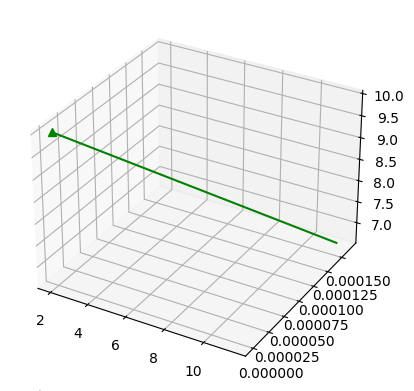

In [35]:
cam0 = Camera(cam_pos, R, thetaH, thetaV, pan, tilt)

print(cam0.get_direc(0)[0])

import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(cam_pos[0], cam_pos[1], cam_pos[2], '^g')
ax.plot3D(cam0.get_direc(0)[0], cam0.get_direc(0)[1], cam0.get_direc(0)[2], '-g')
plt.show()

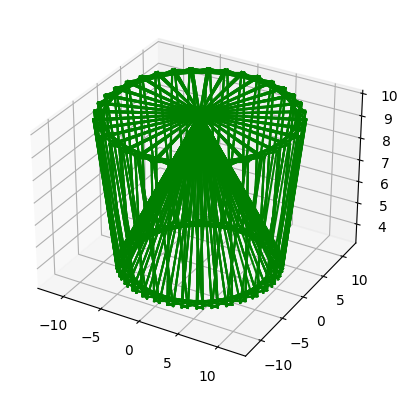

In [24]:
import matplotlib.animation as animation

cam0 = Camera(cam_pos, R, thetaH, thetaV, pan, tilt)

fig = plt.figure()
ax = plt.axes(projection='3d')

def animate(n):
    vertex = cam0.get_vertex(n)
    ax.plot3D(cam_pos[0], cam_pos[1], cam_pos[2], '^g')
    for i in range(4):
        ax.plot3D([vertex[str(i%4)][0][0], vertex[str((i+1)%4)][0][0]], [vertex[str(i%4)][1][0], vertex[str((i+1)%4)][1][0]], [vertex[str(i%4)][2][0], vertex[str((i+1)%4)][2][0]], '-g')
        ax.plot3D([cam_pos[0], vertex[str(i%4)][0][0]], [cam_pos[1], vertex[str(i%4)][1][0]], [cam_pos[2], vertex[str(i%4)][2][0]], '-g')
    plt.gca().relim()
    plt.gca().autoscale_view()

anim = animation.FuncAnimation(fig, animate, frames=100, interval=100)
anim.save('test.mp4')

In [ ]:
def rand_conf(rnt):
    # Random
    r = rn.uniform(0, rnt*dQ)
    theta = rn.uniform(0, 2*np.pi)
    psi = rn.uniform(0, 2*np.pi)

    x = r*np.cos(psi)*np.cos(theta)
    y = r*np.cos(psi)*np.sin(theta)
    z = r*np.sin(psi)

    return np.array([x, y, z])

In [ ]:
def nearest_vertex(qrand, G):
    num_node = len(G['node'])
    dist_vec = []
    for i in range(num_node):
        qcheck = G['node'][i]
        dq = qrand-qcheck
        dist_vec.append(np.sqrt((dq[0])**2+(dq[1])**2+(dq[2])**2))
    nearest = dist_vec.index(min(dist_vec))
    return G['node'][nearest], G['t'][nearest]

In [ ]:
def inside_map(qrand):
    if qrand[0] >= map_size[0] and qrand[0] <= map_size[1] and qrand[1] >= map_size[2] and qrand[1] <= map_size[3] and qrand[2] >= map_size[4] and qrand[2] <= map_size[5]:
        return True
    else:
        return False 

In [ ]:
def outside_building(qrand, building):
    qrandxy = Point(qrand[0:2])

    check_vec = []

    for nb in range(building['nb']):
        building_polygon = Polygon(building[str(nb)]['Polygon'])
        building_height = building[str(nb)]['height']
    
        if not building_polygon.contains(qrandxy) and qrand[2] >= 0 and qrand[2] <= building_height:
            check_vec.append(1)
        else:
            check_vec.append(0)

    if np.sum(check_vec) == building['nb']:
        return True
    else:
        return False

In [ ]:
def outside_FOV(qrand, cam_i):
    # camera: Camera obj
    # To check if it is in 3D:
    # 1. Project point into camera FOV vector, and measure distance from origin: r
    # 2. if that point is inbetween 0 and R:
    #    2.1 Measure distance from FOV vector
    #    2.2 If point is outside of FOV at given r, False
    #    2.3 If point at r is in FOV at given r, True
    dir = cam_i.
    cone_dist = np.dot(p - x, dir)

    pass

In [ ]:
def new_conf(qnear, qrand, dQ, tprev, rnt):
    # get normal direction vector
    dist = qrand - qnear
    norm = np.sqrt(dist[0]**2 + dist[1]**2 + dist[2]**2)
    direction = dist / norm

    dist_travel = np.linspace(0, dQ*rnt, 1000)

    for tt in dist_travel:
        qnew = qnear + direction*tt
        if inside_map(qnew) == False or outside_building(qnew, building) == False:
            return qnew, tprev+tt
    return qnew, tprev+rnt

In [ ]:
# RRT
G = {}
G['t'] = []
G['t'].append(0)
G['node'] = []
G['node'].append(x0)
G['edge'] = []

qprev = x0
tprev = 0
counter = 1

for k in range(K):
#while True:
    print(counter)
    # Sample Time
    rnt = rn.uniform(0.1, trange)

    next = True
    while next:
        # Sample new
        weight_vec = np.array([0.9, 0.1])
        weight = rn.uniform(0, 1)

        if weight < weight_vec[0]:
            #print('Random')
            qrand = rand_conf(rnt)
        elif weight >= weight_vec[0] and weight <= (weight_vec[0] + weight_vec[1]):
            #print('To Final Point')
            dq = xf - qprev
            norm = np.sqrt(dq[0]**2 + dq[1]**2 + dq[2]**2)
            direc = dq/norm*dQ*rnt
            qrand = qprev + direc
        
        if inside_map(qrand) == True and outside_building(qrand, building) == True:
            next = False
            break

    qnear, tnear = nearest_vertex(qrand, G)
    qnew, tnew = new_conf(qnear, qrand, dQ, tprev, rnt)
    G['node'].append(qnew)
    G['edge'].append((qnear, qnew))
    G['t'].append(tnew)
    qprev = qnew
    tprev = tnew
    counter += 1
    
    # Check if final point reached
    dq = qnew - xf
    dist = np.sqrt(dq[0]**2+dq[1]**2+dq[2]**2)
    #print(dist)
    if dist <= tol:
        print('Destination Reached')
        break

1
To Final Point
2
Random
3
Random
Random
Random
Random
To Final Point
4
Random
Random
To Final Point
5
To Final Point
Random
Random
6
Random
Random
Random
Random
To Final Point
7
To Final Point
8
Random
Random
9
Random
Random
Random
10
Random
Random
To Final Point
11
Random
To Final Point
12
Random
Random
13
Random
To Final Point
14
Random
Random
Random
15
Random
Random
Random
Random
Random
Random
16
Random
Random
17
Random
To Final Point
18
Random
To Final Point
19
Random
Random
To Final Point
20
To Final Point
21
Random
Random
Random
Random
Random
Random
Random
Random
To Final Point
22
Random
To Final Point
23
Random
Random
To Final Point
24
Random
Random
Random
Random
Random
To Final Point
25
Random
26
Random
Random
Random
Random
Random
Random
To Final Point
27
Random
Random
Random
Random
Random
Random
To Final Point
28
Random
Random
29
To Final Point
30
Random
To Final Point
31
Random
To Final Point
32
Random
Random
Random
Random
To Final Point
33
Random
Random
Random
Random
Rando

In [ ]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

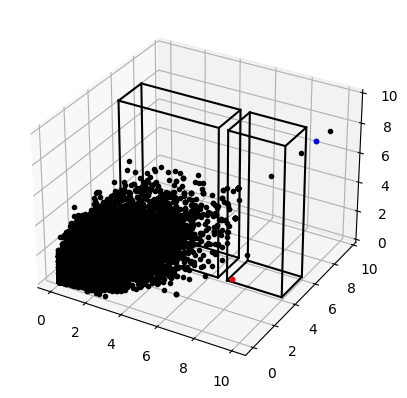

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    bz = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
            bz.append(building[str(nb)]['height'])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
            bz.append(building[str(nb)]['height'])
    ax.plot3D(bx, by, bz, '-k')
    ax.plot3D(bx, by, np.zeros(len(b)+1,), '-k')
    
    for i in range(len(b)):
        ax.plot3D([bx[i], bx[i]], [by[i], by[i]], [0, building[str(nb)]['height']], '-k')

for kk in range(len(G['node'])):
    qcurr = G['node'][kk]
    ax.plot3D(qcurr[0], qcurr[1], qcurr[2], '.k')

ax.plot3D(x0[0], x0[1], x0[2], '.r')
ax.plot3D(xf[0], xf[1], xf[2], '.b')
#ax.set_xlim(map_size[0], map_size[1])
#ax.set_ylim(map_size[2], map_size[3])
#ax.set_zlim(map_size[4], map_size[5])

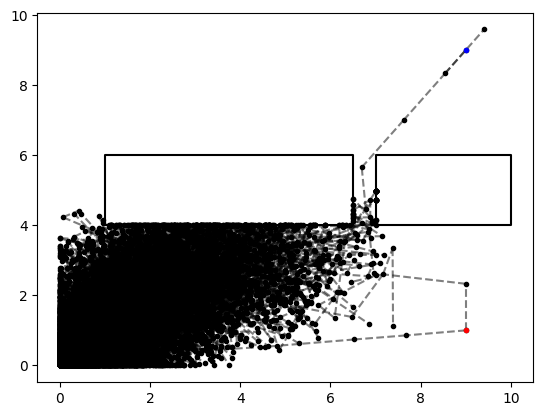

In [ ]:
fig = plt.figure()
ax = plt.axes()

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
    ax.plot(bx, by, '-k')
    
for kk in range(len(G['node'])):
    qcurr = G['node'][kk]
    ax.plot(qcurr[0], qcurr[1], '.k')
for kk in range(len(G['edge'])):
    edgecurr = G['edge'][kk]
    ax.plot([edgecurr[0][0], edgecurr[1][0]], [edgecurr[0][1], edgecurr[1][1]], '--k', alpha=0.5)

ax.plot(x0[0], x0[1], '.r')
ax.plot(xf[0], xf[1], '.b')
#ax.set_xlim(map_size[0], map_size[1])
#ax.set_ylim(map_size[2], map_size[3])

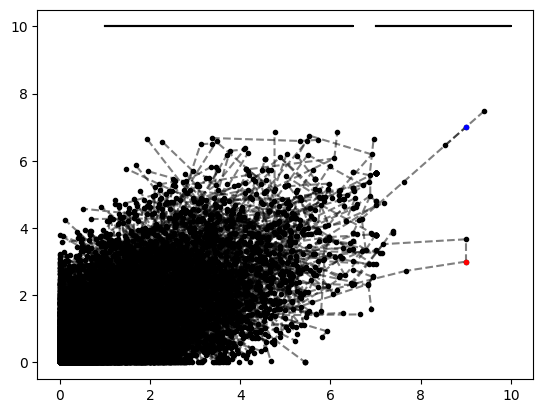

In [ ]:
fig = plt.figure()
ax = plt.axes()

for nb in range(building['nb']):
    b = building[str(nb)]['Polygon']
    bx = []
    by = []
    for i in range(len(b)+1):
        if i < len(b):
            bx.append(b[i][0])
            by.append(b[i][1])
        else:
            bx.append(b[i-len(b)][0])
            by.append(b[i-len(b)][1])
    ax.plot(bx, bz, '-k')
    
for kk in range(len(G['node'])):
    qcurr = G['node'][kk]
    ax.plot(qcurr[0], qcurr[2], '.k')
for kk in range(len(G['edge'])):
    edgecurr = G['edge'][kk]
    ax.plot([edgecurr[0][0], edgecurr[1][0]], [edgecurr[0][2], edgecurr[1][2]], '--k', alpha=0.5)

ax.plot(x0[0], x0[2], '.r')
ax.plot(xf[0], xf[2], '.b')
#ax.set_xlim(map_size[0], map_size[1])
#ax.set_ylim(map_size[2], map_size[3])

In [ ]:
print(G['node'])
print(G['t'])

[array([9, 1, 3]), array([9.        , 2.32996912, 3.66498456]), array([7.67515213, 0.85635591, 2.72555614]), array([7.16586399, 2.6002535 , 3.51961457]), array([7.37788344, 3.34004093, 3.92193447]), array([6.52847146, 0.74015105, 2.34097749]), array([6.46985455, 1.38463817, 2.30173149]), array([6.46372093, 2.38026587, 2.37632068]), array([4.80820767, 0.55893285, 1.72983881]), array([4.54116946, 0.52782809, 1.63903076]), array([5.00093252, 1.7315407 , 2.38653745]), array([5.1414356 , 1.98691047, 2.54862667]), array([3.29085982, 0.43464266, 1.47775805]), array([3.07387972, 2.09385165, 2.43383465]), array([2.70185479, 0.36733423, 1.2632262 ]), array([1.88050684, 0.28669587, 0.91827762]), array([-0.00108345,  0.06751886,  0.06879461]), array([-0.00108345,  0.06751886,  0.06879461]), array([-0.00108345,  0.06751886,  0.06879461]), array([-0.00108345,  0.06751886,  0.06879461]), array([-0.00108345,  0.06751886,  0.06879461]), array([-0.00108345,  0.06751886,  0.06879461]), array([-0.00108345